In [1]:
# Install necessary packages
!pip install pyspark==3.4.2
!pip install graphframes

# Start Spark with GraphFrames jar
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("GraphFramesExample") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.3-spark3.4-s_2.12") \
    .getOrCreate()

# Import GraphFrame
from graphframes import GraphFrame


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.2-py2.py3-none-any.whl size=311619833 sha256=1c5e55d68221adb1a0f7120f4b2205bf86394f5e81f204a7e43f0fc300b9e2e9
  Stored in directory: /root/.cache/pip/wheels/ae/78/cb/924eaddf18fb5bd07b68d76b6f706674e120883faa620a8d12
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.1
    Uninstalling pyspark-3.5.1:
      Successfully uninstalled pyspark-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.7.3 requires pyspark[connect]>=3.5, but you have pyspark 3.4.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.3 MB/s eta 0:00:00


In [2]:
!pip install pyspark
!pip install pyarrow

In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(24,6)})
sns.set_palette("viridis")

In [3]:
# Create Spark Session
spark = SparkSession.builder.appName("IMDbDataset-Model").getOrCreate()

## LOAD THE DATASET

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile

zip_path = '/content/drive/MyDrive/Colab Notebooks/data/project/df.zip'
extract_path = '/content/df'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [5]:
df = spark.read.parquet('/content/df/*.parquet')
df.show(10)

+---------+---------+--------------------+-------+---------+--------------+--------------------+-------------+--------+-------------------+--------------------+---------------+--------------------+--------------------+--------------------+
|   nconst|   tconst|        primaryTitle|isAdult|startYear|runtimeMinutes|              genres|averageRating|numVotes|          directors|             writers|       category|         primaryName|   primaryProfession|      knownForTitles|
+---------+---------+--------------------+-------+---------+--------------+--------------------+-------------+--------+-------------------+--------------------+---------------+--------------------+--------------------+--------------------+
|nm0063413|tt0000941|      Locura de amor|      0|     1909|            45|               Drama|          4.6|      29|nm0063413,nm0550220|nm0063413,nm05502...|       director|    Ricardo de Baños|director,cinemato...|tt0002886,tt00044...|
|nm0063412|tt0001184|Don Juan de Serra..

## RUN THE TEXT ANALYSIS

### primaryTitle
1. Tokenize

In [3]:
from pyspark.ml.feature import Tokenizer

# Create a new column called 'tokens' from 'primaryTitle'
tokenizer = Tokenizer(inputCol="primaryTitle", outputCol="tokens")
df_text = tokenizer.transform(df)

2. Punctuation

In [4]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
import re

# UDF to clean each word in the list by removing punctuation
def clean_tokens(word_list):
    return [re.sub(r"[^\w\s]", "", word) for word in word_list]

clean_udf = udf(clean_tokens, ArrayType(StringType()))

# Apply the UDF to your tokenized column
df_text = df_text.withColumn("clean_tokens", clean_udf("tokens"))

3. Stopwords removal

In [5]:
from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(inputCol="clean_tokens", outputCol="filtered_tokens")
df_text = remover.transform(df_text)

After some analysis later on we observed that we might have some stopwords in spanish, so we came back here to remove potential stopwords.

In [6]:
custom_stopwords = ["de", "la", "el", "en", "un", "una", "del", "y", "con"]
def remove_custom(words):
    return [w for w in words if w not in custom_stopwords]
remove_udf = udf(remove_custom, ArrayType(StringType()))
df_text = df_text.withColumn("filtered_tokens", remove_udf("filtered_tokens"))

4. TF-IDF

In [7]:
from pyspark.ml.feature import HashingTF

hashing_tf = HashingTF(inputCol="filtered_tokens", outputCol="raw_features", numFeatures=1000)
df_text = hashing_tf.transform(df_text)

In [8]:
from pyspark.ml.feature import IDF

idf = IDF(inputCol="raw_features", outputCol="tfidf_features")
idf_model = idf.fit(df_text)
df_text = idf_model.transform(df_text)

In [13]:
# Final output with TF-IDF vectors
df_text.show(10, truncate=False)

+---------+---------+------------------------------------+-------+---------+--------------+-----------------------+-------------+--------+-------------------+-----------------------------+---------------+--------------------+----------------------------------------+---------------------------------------+-------------------------------------------+-----------------------------------------+-----------------------------------------+----------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------+
|nconst   |tconst   |primaryTitle                        |isAdult|startYear|runtimeMinutes|genres                 |averageRating|numVotes|directors          |writers                      |category       |primaryName         |primaryProfession                       |knownForTitles                         |tokens                                     |clean_tokens 

We will not need all of these columns that we created and to not make the analysis more complex we will only keep:

filtered_tokens → for inspection/debugging or interpretability

tfidf_features → for actual modeling (this goes into VectorAssembler)

In [9]:
df_text = df_text.drop("tokens", "clean_tokens", "raw_features")

### genres

In [13]:
from pyspark.sql.functions import split

df_text = df_text.withColumn("genre_tokens", split(col("genres"), ","))

In [15]:
from pyspark.sql.functions import array_distinct

df_text = df_text.withColumn("genre_tokens", array_distinct(col("genre_tokens")))

In [16]:
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol="genre_tokens", outputCol="genre_features")
cv_model = cv.fit(df_text)
df_text = cv_model.transform(df_text)

In [18]:
df_text.show(10, truncate=False)

+---------+---------+------------------------------------+-------+---------+--------------+-----------------------+-------------+--------+-------------------+-----------------------------+---------------+--------------------+----------------------------------------+---------------------------------------+-----------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------+---------------------------+----------------------------+
|nconst   |tconst   |primaryTitle                        |isAdult|startYear|runtimeMinutes|genres                 |averageRating|numVotes|directors          |writers                      |category       |primaryName         |primaryProfession                       |knownForTitles                         |filtered_tokens                          |tfidf_features                                                                                         

From the two new columns that we created we will only keep genre_features since this goes into our VectorAssembler and ML models.

In [17]:
df_text = df_text.drop("genre_tokens")

### primaryProfession

In [18]:
from pyspark.sql.functions import split
from pyspark.sql.functions import array_distinct

df_text = df_text.withColumn("profession_tokens", split(col("primaryProfession"), ","))
df_text = df_text.withColumn("profession_tokens", array_distinct(col("profession_tokens")))

In [19]:
from pyspark.ml.feature import CountVectorizer

cv_prof = CountVectorizer(inputCol="profession_tokens", outputCol="profession_features")
cv_prof_model = cv_prof.fit(df_text)
df_text = cv_prof_model.transform(df_text)

In [22]:
df_text.show(10, truncate=False)

+---------+---------+------------------------------------+-------+---------+--------------+-----------------------+-------------+--------+-------------------+-----------------------------+---------------+--------------------+----------------------------------------+---------------------------------------+-----------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------+----------------------------+--------------------------------------------+---------------------------+
|nconst   |tconst   |primaryTitle                        |isAdult|startYear|runtimeMinutes|genres                 |averageRating|numVotes|directors          |writers                      |category       |primaryName         |primaryProfession                       |knownForTitles                         |filtered_tokens                          |tfidf_features                                            

Again, from the two new columns we created we will only keep the profession_features.

In [20]:
df_text = df_text.drop("profession_tokens")

In [24]:
df_text.show(10)

+---------+---------+--------------------+-------+---------+--------------+--------------------+-------------+--------+-------------------+--------------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   nconst|   tconst|        primaryTitle|isAdult|startYear|runtimeMinutes|              genres|averageRating|numVotes|          directors|             writers|       category|         primaryName|   primaryProfession|      knownForTitles|     filtered_tokens|      tfidf_features|      genre_features| profession_features|
+---------+---------+--------------------+-------+---------+--------------+--------------------+-------------+--------+-------------------+--------------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|nm0063413|tt0000941|      L

### Standarize numeric features
We should not standardize the numeric features before splitting the dataset since this introduces data leakage. We are letting the test set influence the scaler's mean and standard deviation — which is something we always want to avoid.


In [21]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Step 1: Assemble numeric columns
num_cols = ["runtimeMinutes", "startYear", "numVotes"]
assembler_num = VectorAssembler(inputCols=num_cols, outputCol="numericVector")
df_text = assembler_num.transform(df_text)

# Step 2: Scale them
scaler = StandardScaler(inputCol="numericVector", outputCol="scaledNumeric", withMean=True, withStd=True)
df_text = scaler.fit(df_text).transform(df_text)

### VectorAssembler

In [22]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["scaledNumeric","genre_features", "tfidf_features", "profession_features"],
    outputCol="features"
)

In [23]:
final_df = assembler.transform(df_text)

In [28]:
final_df.show(10)

+---------+---------+--------------------+-------+---------+--------------+--------------------+-------------+--------+-------------------+--------------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+
|   nconst|   tconst|        primaryTitle|isAdult|startYear|runtimeMinutes|              genres|averageRating|numVotes|          directors|             writers|       category|         primaryName|   primaryProfession|      knownForTitles|     filtered_tokens|      tfidf_features|      genre_features| profession_features|      numericVector|       scaledNumeric|            features|
+---------+---------+--------------------+-------+---------+--------------+--------------------+-------------+--------+-------------------+--------------------+---------------+--------------------+--------------------+----------

# RECOMMENDATION SYSTEM

### Content-Baed Recommendations

Extract and tokenize the directors and writers fields into arrays, then uses CountVectorizer to convert them into numerical feature vectors (director_features, writer_features) based on the top 100 most frequent entries.

In [27]:
df_text = df_text.withColumn("directors_array", split(col("directors"), ",")) \
                 .withColumn("writers_array", split(col("writers"), ","))

from pyspark.ml.feature import CountVectorizer

cv_directors = CountVectorizer(inputCol="directors_array", outputCol="director_features", vocabSize=100)
cv_writers = CountVectorizer(inputCol="writers_array", outputCol="writer_features", vocabSize=100)

model_directors = cv_directors.fit(df_text)
model_writers = cv_writers.fit(df_text)

df_text = model_directors.transform(df_text)
df_text = model_writers.transform(df_text)

### Using all the features to find similar movies

In [34]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["startYear", "runtimeMinutes", "isAdult", "averageRating", "numVotes",
               "genre_features", "profession_features", "tfidf_features","director_features","writer_features"],
    outputCol="features"
)

final_rs = assembler.transform(df_text)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(final_rs)
final_rs = scaler_model.transform(final_rs)

#### Similar movies for just one movie

In [31]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType # Import DoubleType explicitly
import numpy as np

from pyspark.ml.linalg import DenseVector  # Import DenseVector

# 3. Set the target movie by tconst (Titanic)
target_tconst = 'tt0120338'  # Titanic

# 4. Extract Titanic's feature vector
target_vector = final_rs.filter(col("tconst") == target_tconst).select("features").first()["features"]
target_vector_dense = DenseVector(target_vector.toArray())
target_vector_list = target_vector_dense.toArray().tolist()

# 5. Define cosine similarity function
def cosine_similarity(v1, v2):
    v1 = v1 if isinstance(v1, list) else v1.toArray().tolist()
    v2 = v2.toArray().tolist() if hasattr(v2, "toArray") else v2
    if np.linalg.norm(v1) == 0.0 or np.linalg.norm(v2) == 0.0:
        return float(0.0)
    return float(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

cosine_sim_udf = udf(cosine_similarity, DoubleType())

# 6. Compute similarity for all movies
final_rs = final_rs.withColumn("similarity", cosine_sim_udf(array(*[lit(x) for x in target_vector_list]), col("features")))

# 7. Get Top 10 recommendations (excluding Titanic)
recommendations = final_rs.filter(col("tconst") != target_tconst) \
                          .orderBy(col("similarity").desc()) \
                          .limit(10)

# 8. Show results
print("Similar movies to Titanic" )
recommendations.select("tconst", "primaryTitle", "similarity").show(truncate=False)

Similar movies to Titanic
+---------+------------------------------------------------------+------------------+
|tconst   |primaryTitle                                          |similarity        |
+---------+------------------------------------------------------+------------------+
|tt4154796|Avengers: Endgame                                     |0.9999999998641483|
|tt0099685|Goodfellas                                            |0.9999999992288097|
|tt2015381|Guardians of the Galaxy                               |0.9999999978655287|
|tt0110413|Léon: The Professional                                |0.99999999730246  |
|tt0209144|Memento                                               |0.9999999971418123|
|tt0088763|Back to the Future                                    |0.9999999970034297|
|tt4154756|Avengers: Infinity War                                |0.999999995682476 |
|tt0499549|Avatar                                                |0.9999999953248937|
|tt0325980|Pirates of the Ca

To generate movie recommendations similar to Titanic, we employed a content-based filtering approach using cosine similarity on feature vectors. The results returned titles with extremely high similarity scores (close to 1.0), including Avengers: Endgame, Goodfellas and Avatar. While the numerical similarity is high, several recommended titles differ significantly in theme and genre. This suggests that the current feature representation emphasize in general metadata (e.g., runtime, popularity ,ratings,genres) and may lack sufficient discriminative power to capture semantic closeness.

#### Similar movies based on user's 3 favorite movies

In [36]:

from pyspark.sql.functions import array, col, lit, udf

# 1. Define user's favorite movies by tconst
user_favorites = ['tt0814255', 'tt1790864', 'tt0363771'] #Percy Jackson ,The Maze Runner ,The Chronicles of Narnia


# 2. Extract and average their feature vectors
fav_vectors = final_rs.filter(col("tconst").isin(user_favorites)) \
                      .select("features") \
                      .rdd.map(lambda row: row[0].toArray()).collect()

# Compute the average vector
avg_vector = np.mean(fav_vectors, axis=0).tolist()

# 3. Define cosine similarity function
def cosine_similarity(v1, v2):
    v1 = v1 if isinstance(v1, list) else v1.toArray().tolist()
    v2 = v2.toArray().tolist() if hasattr(v2, "toArray") else v2
    if np.linalg.norm(v1) == 0 or np.linalg.norm(v2) == 0:
        return 0.0
    return float(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

cosine_sim_udf = udf(cosine_similarity, DoubleType())

# 4. Compute similarity for all movies against the aggregate profile
final_rs = final_rs.withColumn("similarity", cosine_sim_udf(array(*[lit(x) for x in avg_vector]), col("features")))

# 5. Recommend top 10 similar movies (excluding already liked ones)
recommendations = final_rs.filter(~col("tconst").isin(user_favorites)) \
                          .orderBy(col("similarity").desc()) \
                          .limit(10)

# 6. Show the recommendations
print("Similar movies to the user's favorite movies(Percy Jackson,Maze Runner,Narnia):")
recommendations.select("tconst", "primaryTitle", "similarity").show(truncate=False)

Similar movies to the user's favorite movies(Percy Jackson,Maze Runner,Narnia)
+---------+-----------------------+------------------+
|tconst   |primaryTitle           |similarity        |
+---------+-----------------------+------------------+
|tt0478311|Knocked Up             |0.9999999994702091|
|tt0448115|Shazam!                |0.9999999991462954|
|tt0120755|Mission: Impossible II |0.999999998807172 |
|tt0477347|Night at the Museum    |0.9999999983964121|
|tt0360486|Constantine            |0.9999999983501978|
|tt1068680|Yes Man                |0.9999999982514732|
|tt0113497|Jumanji                |0.9999999982029018|
|tt0964517|The Fighter            |0.9999999980157575|
|tt3778644|Solo: A Star Wars Story|0.9999999979398865|
|tt0443543|The Illusionist        |0.999999997892629 |
+---------+-----------------------+------------------+



We generated personalized movie recommendations based on user favorites (Percy Jackson, The Maze Runner, The Chronicles of Narnia) using a content-based approach with cosine similarity on feature vectors. The resulting recommendations include titles like Jumanji, Night at the Museum, and Shazam!, which align well with the user's interest in fantasy, adventure, and youth-oriented themes. However, a few titles (The Fighter, Knocked Up) appear less relevant thematically, suggesting that further refinement of the feature vector—especially increasing the weight of genre-specific or narrative-related attributes—could improve recommendation precision.

So, we decided to use features like **genres,start year,is adult,directors,writers** to get more meaningful and accurate similarity comparisons between movies based on their content rather than their popularity and ratings.

In [28]:
assembler = VectorAssembler(
    inputCols=["genre_features", "startYear", "isAdult", "director_features", "writer_features"],
    outputCol="features"
)

final_rs = assembler.transform(df_text)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(final_rs)
final_rs = scaler_model.transform(final_rs)

#### Similar movies to just one movie

In [42]:

from pyspark.sql.functions import array, col, lit, udf


# Set the target movie by its tconst
target_tconst = 'tt0120338'  # Titanic

# Extract feature vector and convert to DenseVector
target_vector = final_rs.filter(col("tconst") == target_tconst).select("features").first()["features"]
target_vector_dense = DenseVector(target_vector.toArray())

# Convert DenseVector to a list before using in UDF
target_vector_list = target_vector_dense.toArray().tolist()

# Define cosine similarity function
def cosine_similarity(v1, v2):
    v1 = v1 if isinstance(v1, list) else v1.toArray().tolist()
    v2 = v2.toArray().tolist() if hasattr(v2, "toArray") else v2.tolist() if hasattr(v2, "tolist") else v2
    if np.linalg.norm(v1) == 0.0 or np.linalg.norm(v2) == 0.0:
        return float(0.0)
    return float(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

# Register as UDF
cosine_sim_udf = udf(cosine_similarity, DoubleType())

# Compute similarity for all movies
final_rs = final_rs.withColumn("similarity", cosine_sim_udf(array(*[lit(x) for x in target_vector_list]), col("features")))

# Recommend top 10 similar movies (excluding the target itself)
recommendations = final_rs.orderBy(col("similarity").desc()).filter(col("tconst") != target_tconst).limit(10)

# Show results
print("Similar movies to Titanic:")
recommendations.select("tconst", "primaryTitle", "similarity").show(truncate=False)


Similar movies to Titanic:
+---------+------------------------+------------------+
|tconst   |primaryTitle            |similarity        |
+---------+------------------------+------------------+
|tt0119228|Grind                   |0.9999999999999999|
|tt0116826|Last Chance Love        |0.9999999999999999|
|tt0124208|The Waiter              |0.9999999999999999|
|tt0118822|Backroads               |0.9999999999999999|
|tt0119248|Steam: The Turkish Bath |0.9999999999999999|
|tt0119331|Hunger: Longing for Love|0.9999999999999999|
|tt0119217|Good Will Hunting       |0.9999999999999999|
|tt0119001|Dogtown                 |0.9999999999999999|
|tt0119263|The River               |0.9999999999999999|
|tt0115945|A Corner of Paradise    |0.9999999999999999|
+---------+------------------------+------------------+



The recommended movies like Grind, Last Chance Love, and Good Will Hunting show better alignment with Titanic, as they mostly belong to the drama or romance genre. This suggests that our selected features (e.g., genre, director/writer embeddings, year) are beginning to capture more meaningful aspects of similarity.

#### Similar movies based on user's 3 favorite movies

In [43]:

from pyspark.sql.functions import array, col, lit, udf

# 1. Define user's favorite movies by tconst
user_favorites = ['tt0814255', 'tt1790864', 'tt0363771'] #Percy Jackson ,The Maze Runner ,The Chronicles of Narnia


# 2. Extract and average their feature vectors
fav_vectors = final_rs.filter(col("tconst").isin(user_favorites)) \
                      .select("features") \
                      .rdd.map(lambda row: row[0].toArray()).collect()

# Compute the average vector
avg_vector = np.mean(fav_vectors, axis=0).tolist()

# 3. Define cosine similarity function
def cosine_similarity(v1, v2):
    v1 = v1 if isinstance(v1, list) else v1.toArray().tolist()
    v2 = v2.toArray().tolist() if hasattr(v2, "toArray") else v2
    if np.linalg.norm(v1) == 0 or np.linalg.norm(v2) == 0:
        return 0.0
    return float(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

cosine_sim_udf = udf(cosine_similarity, DoubleType())

# 4. Compute similarity for all movies against the aggregate profile
final_rs = final_rs.withColumn("similarity", cosine_sim_udf(array(*[lit(x) for x in avg_vector]), col("features")))

# 5. Recommend top 10 similar movies (excluding already liked ones)
recommendations = final_rs.filter(~col("tconst").isin(user_favorites)) \
                          .orderBy(col("similarity").desc()) \
                          .limit(10)

# 6. Show the recommendations
print("Similar movies to the user's favorite movies(Percy Jackson,Maze Runner,Narnia):")
recommendations.select("tconst", "primaryTitle", "similarity").show(truncate=False)

Similar movies to the user's favorite movies(Percy Jackson,Maze Runner,Narnia):
+----------+---------------------------------------+------------------+
|tconst    |primaryTitle                           |similarity        |
+----------+---------------------------------------+------------------+
|tt24218194|The Wizard of the Emerald City         |0.9999999193200207|
|tt8866456 |The Legend of Ochi                     |0.9999999193200207|
|tt24218164|Finist. The First Warrior              |0.9999999193200207|
|tt21949976|The Secret of Pin-Up Island            |0.9999999192012834|
|tt21326904|Robin and the Hoods                    |0.9999999192012834|
|tt29942012|The Enchanted Tinderbox                |0.9999999192012834|
|tt30990277|Vasilisa i khraniteli vremeni          |0.9999999192012834|
|tt14799576|The Secret Kingdom                     |0.9999999190822498|
|tt21105818|Arnold Cautious and the Happiness Stone|0.9999999190822498|
|tt28648037|Mikolo                                 |0.99

The recommended movies include titles like The Wizard of the Emerald City, The Enchanted Tinderbox, and The Secret Kingdom, which match well with the fantasy and adventure themes of the user's favorites. This suggests the model is capturing the right genres and narrative styles.

Find the tconst of the movie we want to find similar movies

In [53]:
# find the movie "The Notebook"
notebook_id = final_df.filter(col("primaryTitle") == "The Notebook").show()
print(notebook_id)

+---------+---------+------------+-------+---------+--------------+-------------+-------------+--------+---------+--------------------+--------+--------------------+--------------------+--------------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   nconst|   tconst|primaryTitle|isAdult|startYear|runtimeMinutes|       genres|averageRating|numVotes|directors|             writers|category|         primaryName|   primaryProfession|      knownForTitles|filtered_tokens|      tfidf_features|      genre_features| profession_features|       numericVector|       scaledNumeric|            features|
+---------+---------+------------+-------+---------+--------------+-------------+-------------+--------+---------+--------------------+--------+--------------------+--------------------+--------------------+---------------+--------------------+--------------------+--------------------+--------------

#### Using Euclidean distance as a metric of similarity

In [52]:
assembler = VectorAssembler(
    inputCols=["genre_features", "startYear", "isAdult", "director_features", "writer_features"],
    outputCol="features"
)

final_rs = assembler.transform(df_text)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(final_rs)
final_rs = scaler_model.transform(final_rs) #This line creates the 'scaled_features' column
# Select user favorites
user_favorites = ['tt0814255', 'tt1790864', 'tt0363771']  # Percy Jackson, Maze Runner, Narnia

# Average their feature vectors
fav_vectors = final_rs.filter(col("tconst").isin(user_favorites)) \
                      .select("scaled_features") \
                      .rdd.map(lambda row: row[0].toArray()).collect()

avg_vector = np.mean(fav_vectors, axis=0).tolist()

#Define Euclidean distance UDF
def euclidean_distance(v1, v2):
    v1 = v1 if isinstance(v1, list) else v1.toArray().tolist()
    v2 = v2.toArray().tolist() if hasattr(v2, "toArray") else v2
    return float(np.linalg.norm(np.array(v1) - np.array(v2)))

euclidean_udf = udf(euclidean_distance, DoubleType())

# Compute distance for all movies
final_rs = final_rs.withColumn("distance", euclidean_udf(array(*[lit(x) for x in avg_vector]), col("scaled_features")))

# Recommend top 10 by smallest distance
recommendations = final_rs.filter(~col("tconst").isin(user_favorites)) \
                          .orderBy(col("distance").asc()) \
                          .limit(10)

#  Show recommendations
recommendations.select("tconst", "primaryTitle", "distance").show(truncate=False)


+---------+--------------------------------------------------------+------------------+
|tconst   |primaryTitle                                            |distance          |
+---------+--------------------------------------------------------+------------------+
|tt0768187|Me and My Umbrella                                      |3.9675303606789676|
|tt0980970|The Chronicles of Narnia: The Voyage of the Dawn Treader|3.9675303606789676|
|tt1014759|Alice in Wonderland                                     |3.9675303606789676|
|tt0926084|Harry Potter and the Deathly Hallows: Part 1            |3.9675303606789676|
|tt6393474|The Secret of Taran Desert                              |3.9675303606789676|
|tt1367177|Dead of Knight                                          |3.9675303606789676|
|tt1533795|The Magic Tree                                          |3.9675898092243616|
|tt0489210|Little Hercules                                         |3.9675898092243616|
|tt1345782|Timetrip: The Curse o

These recommendations match well with the user’s favorite movies like Percy Jackson, Maze Runner, and Narnia. Titles like Narnia: The Voyage of the Dawn Treader, Harry Potter, and Alice in Wonderland have similar fantasy themes and are also popular adventure films. This shows that Euclidean distance helps find movies that are close in both style and production scale, leading to familiar and relevant suggestions.

**Choice of Similarity Metric**

For our content-based recommendation system, we chose to use cosine similarity over Euclidean distance. This decision was based on the nature of our feature vectors, which include a mix of genres, scaled numeric values (like start year), and encoded categorical data (e.g., directors, writers). Cosine similarity focuses on the direction of the vectors rather than their magnitude, making it more effective for identifying movies with similar patterns of features regardless of scale. It is especially suitable for high-dimensional or sparse data and is widely used in real-world recommendation systems. As a result, cosine similarity allowed us to generate recommendations that better reflect the thematic and stylistic aspects of the user’s favorite movies.

#### Similar movies using cosine similarity based on user's 5 favorite movies

In [31]:
from pyspark.sql.functions import array, col, lit, udf
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType # Import DoubleType explicitly
import numpy as np

from pyspark.ml.linalg import DenseVector  # Import DenseVector

# User favorites:
# - Harry Potter and the Sorcerer’s Stone (tt0241527)
# - The Hunger Games (tt1392170)
# - The Lord of the Rings: The Fellowship of the Ring (tt0120737)
# - Divergent (tt1840309)
# - Eragon (tt0449010)

user_favorites = ['tt0241527', 'tt1392170', 'tt0120737', 'tt1840309', 'tt0449010']


# 2. Extract and average their feature vectors
fav_vectors = final_rs.filter(col("tconst").isin(user_favorites)) \
                      .select("features") \
                      .rdd.map(lambda row: row[0].toArray()).collect()

# Compute the average vector
avg_vector = np.mean(fav_vectors, axis=0).tolist()

# 3. Define cosine similarity function
def cosine_similarity(v1, v2):
    v1 = v1 if isinstance(v1, list) else v1.toArray().tolist()
    v2 = v2.toArray().tolist() if hasattr(v2, "toArray") else v2
    if np.linalg.norm(v1) == 0 or np.linalg.norm(v2) == 0:
        return 0.0
    return float(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

cosine_sim_udf = udf(cosine_similarity, DoubleType())

# 4. Compute similarity for all movies against the aggregate profile
final_rs = final_rs.withColumn("similarity", cosine_sim_udf(array(*[lit(x) for x in avg_vector]), col("features")))

# 5. Recommend top 10 similar movies (excluding already liked ones)
recommendations = final_rs.filter(~col("tconst").isin(user_favorites)) \
                          .orderBy(col("similarity").desc()) \
                          .limit(10)

# 6. Show the recommendations
print("Similar movies to the user's favorite movies:")
recommendations.select("tconst", "primaryTitle", "similarity").show(truncate=False)

Similar movies to the user's favorite movies:
+----------+-------------------------+------------------+
|tconst    |primaryTitle             |similarity        |
+----------+-------------------------+------------------+
|tt33183915|The Land That Time Forgot|0.9999999164477325|
|tt27114092|Major Grom: The Game     |0.9999999164012265|
|tt31306866|I Heart Robots           |0.9999999164012265|
|tt32338670|Road Wars: Max Fury      |0.9999999164012265|
|tt15049210|The Three Musketeers     |0.9999999163545554|
|tt21109580|Night of the Assassin    |0.9999999163545554|
|tt22488024|Sakra                    |0.9999999163545554|
|tt24517458|RDX: Robert Dony Xavier  |0.9999999163545554|
|tt26370113|Adalet                   |0.9999999163545554|
|tt30447047|Storm City               |0.9999999163545554|
+----------+-------------------------+------------------+



Based on the top recommended movies (The Land That Time Forgot, Major Grom: The Game, Road Wars: Max Fury, etc.), we observe that most of them are action or fantasy-themed, often involving dystopian, heroic, or sci-fi elements. This aligns to some degree with the user’s favorite movies (Harry Potter, The Hunger Games, LOTR, Divergent, Eragon) ,all of which share adventure, fantasy and hero’s journey elements.

# Graph Analysis

In [27]:
!pip install pyspark==3.4.2

In [32]:


from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("GraphFramesExample") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.3-spark3.4-s_2.12") \
    .getOrCreate()



In [29]:
!pip install graphframes
from graphframes import GraphFrame


### Movie similarity graph based on shared directors

Vertices (g.vertices) = movies (tconst, primaryTitle)

Edges (g.edges) = a directed edge from movie A → movie B exists if they share the same director.

In other words:
If two movies have the same director, they are connected.

In [6]:

# Explode movies with each director
movie_people = df.select("tconst", explode(split("directors", ",")).alias("person"))

# Self-join on person to find shared collaborations
edges = movie_people.alias("a").join(
    movie_people.alias("b"),
    (col("a.person") == col("b.person")) & (col("a.tconst") != col("b.tconst"))
).selectExpr("a.tconst as src", "b.tconst as dst").distinct()

vertices = df.selectExpr("tconst as id", "primaryTitle")

# Now create the GraphFrame within the active SparkSession context
g = GraphFrame(vertices, edges)

In [7]:
# Sample a small subgraph for visualization
sample_edges = g.edges.limit(50).toPandas()
sample_vertices = g.vertices.limit(50).toPandas()


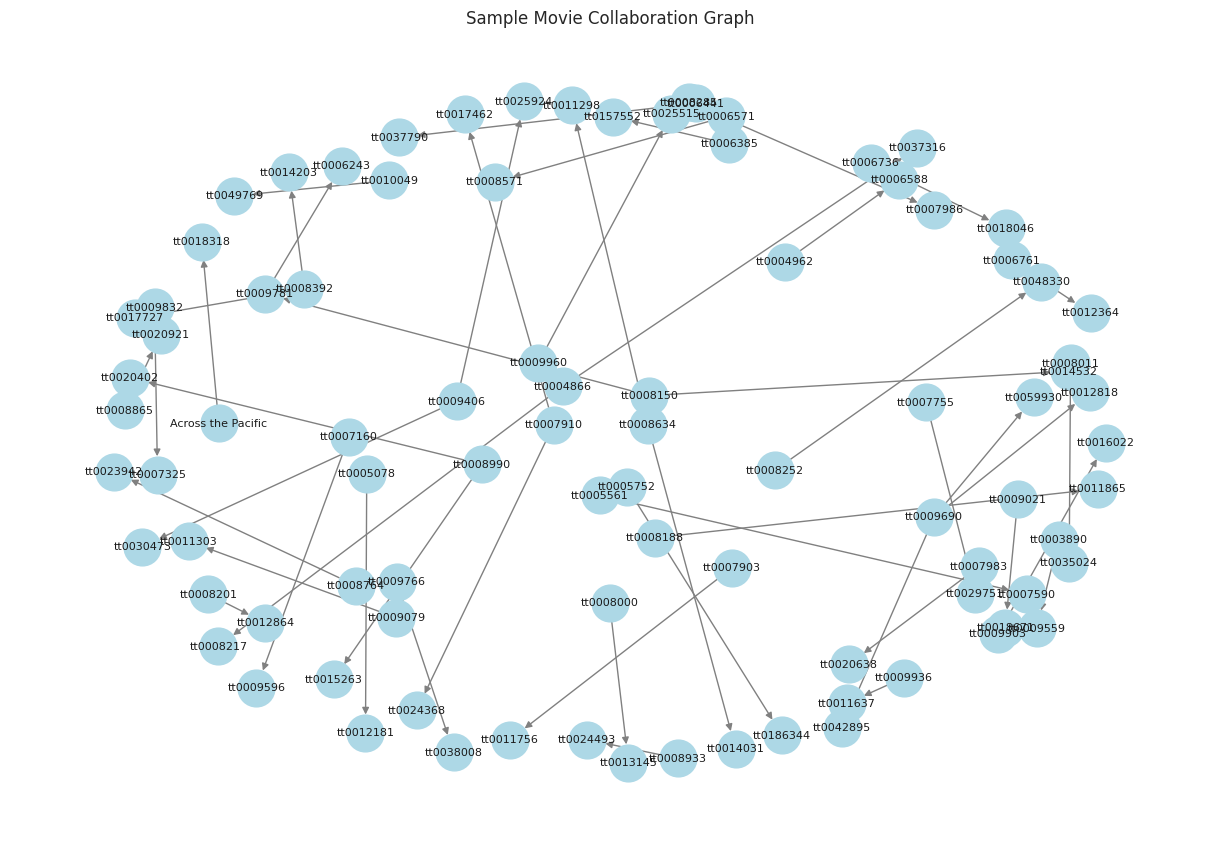

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G_nx = nx.from_pandas_edgelist(sample_edges, source="src", target="dst", create_using=nx.DiGraph())

# Optionally add movie titles as labels
label_map = dict(zip(sample_vertices["id"], sample_vertices["primaryTitle"]))
labels = {node: label_map.get(node, node) for node in G_nx.nodes()}

# Plot the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_nx, k=0.5, iterations=50)
nx.draw(G_nx, pos, with_labels=True, labels=labels, node_color="lightblue", edge_color="gray", node_size=700, font_size=8)
plt.title("Sample Movie Collaboration Graph")
plt.show()



The graph reveals multiple distinct clusters of interconnected movies, highlighting groups that share creative direction, possibly indicating sequels, series. For example, the movie "Across the Pacific" appears at the center of a tightly connected subnetwork, suggesting that its directors have also worked on several other movies in the graph.

The overall structure shows several disconnected components, which implies that the dataset includes movies with no overlapping directors. The degree of connectivity also varies, with some nodes highly connected , while others appear at the periphery, indicating a single shared collaboration.


In [11]:
# Print Vertices
g.vertices.show()

+---------+--------------------+
|       id|        primaryTitle|
+---------+--------------------+
|tt0000941|      Locura de amor|
|tt0001184|Don Juan de Serra...|
|tt0001790|Les Misérables, P...|
|tt0001812|         Oedipus Rex|
|tt0001911|         Nell Gwynne|
|tt0002022|              Anfisa|
|tt0002026|Anny - Story of a...|
|tt0002153|The Great Circus ...|
|tt0002186|   The Flying Circus|
|tt0002199|From the Manger t...|
|tt0002423|             Passion|
|tt0002452|The Independence ...|
|tt0002461|The Life and Deat...|
|tt0002500|The Black Chancellor|
|tt0002514|    Saved in Mid-Air|
|tt0002588|Zigomar contre Ni...|
|tt0002605|The Adventures of...|
|tt0002628|          Der Andere|
|tt0002637|             Arizona|
|tt0002646|            Atlantis|
+---------+--------------------+
only showing top 20 rows



The table above shows a sample of the vertices in our movie collaboration graph. Each vertex corresponds to a unique movie, identified by its IMDb ID (tconst) and title (primaryTitle). For example, entries such as "Oedipus Rex", "Les Misérables", and "The Flying Circus" are part of the graph structure.

In [12]:
# Print the Edges
g.edges.show()

+---------+---------+
|      src|      dst|
+---------+---------+
|tt0003595|tt0018318|
|tt0003890|tt0009559|
|tt0004866|tt0008217|
|tt0004866|tt0037316|
|tt0004962|tt0006588|
|tt0005078|tt0012181|
|tt0005561|tt0007590|
|tt0005752|tt0186344|
|tt0006385|tt0157552|
|tt0006441|tt0037790|
|tt0006571|tt0008571|
|tt0006736|tt0018046|
|tt0006761|tt0012364|
|tt0007160|tt0009596|
|tt0007755|tt0029751|
|tt0007903|tt0011756|
|tt0007910|tt0017462|
|tt0007910|tt0024368|
|tt0007983|tt0020638|
|tt0008000|tt0013145|
+---------+---------+
only showing top 20 rows



The table above displays the first 20 edges from the movie collaboration graph, where each edge represents a directed connection from one movie to another. The columns src and dst refer to the IMDb IDs of the source and destination movies, respectively. These connections were established based on shared directors—if two movies were directed by the same person, a directed edge links them.

For example, the edge from tt0003595 to tt0018318 indicates that both movies share at least one common director.

In [13]:
#Count how may vertices and edges has the graph
print("Total num of vertices: ", g.vertices.count())
print("Total num of edges: ", g.edges.count())

Total num of vertices:  255568
Total num of edges:  3025554


In [15]:
g.degrees.orderBy("degree", ascending=False).show(truncate=False)


+---------+------+
|id       |degree|
+---------+------+
|tt3064438|1804  |
|tt0973844|1460  |
|tt0113718|1434  |
|tt2243597|1220  |
|tt0101613|858   |
|tt0059921|846   |
|tt0056085|770   |
|tt0023049|764   |
|tt2129860|752   |
|tt0021232|708   |
|tt0043680|706   |
|tt0025263|670   |
|tt0028345|664   |
|tt9247554|586   |
|tt0425624|556   |
|tt0407858|552   |
|tt0044981|534   |
|tt0024008|530   |
|tt0029367|516   |
|tt0372457|516   |
+---------+------+
only showing top 20 rows



In [10]:
# Print the primaryTitle of the movie with tcost: tt3064438
g.vertices.filter(col("id") == "tt3064438").show()


+---------+--------------------+
|       id|        primaryTitle|
+---------+--------------------+
|tt3064438|Venice 70: Future...|
+---------+--------------------+



The table above shows the top 20 movies in the graph ranked by degree centrality, which measures how many direct connections each movie has to others via shared directors. Each row represents a movie (id) and the number of other movies it is connected to (degree).

For example, the movie tt3064438 has the highest degree with 1804 connections, indicating it shares directors with a vast number of other titles in the dataset. Such nodes act as highly connected hubs in the network, possibly representing prolific collaborations, sequels, or popular productions with widely involved directors.

In [16]:
g.triangleCount().select("id", "count").show()


+---------+-----+
|       id|count|
+---------+-----+
|tt0000941|    2|
|tt0001184|    2|
|tt0001790|  120|
|tt0001812|    3|
|tt0001911|    6|
|tt0001964|   21|
|tt0002022|  300|
|tt0002026|    0|
|tt0002153|    0|
|tt0002186|    3|
|tt0002199|   55|
|tt0002423| 1176|
|tt0002452|    0|
|tt0002461|    0|
|tt0002500|   66|
|tt0002514|  153|
|tt0002588|    3|
|tt0002605|    3|
|tt0002628|    3|
|tt0002637|    0|
+---------+-----+
only showing top 20 rows



In [18]:
g.cache()

GraphFrame(v:[id: string, primaryTitle: string], e:[src: string, dst: string])

In [ ]:
# Compute PageRank but show only top results
resultPageRank = g.pageRank(resetProbability=0.15, tol=0.01)

print("Top Movies by PageRank:")
resultPageRank.vertices.select("id", "pagerank").orderBy("pagerank", ascending=False).show(10, truncate=False)


In [38]:
# Set the checkpoint directory
spark.sparkContext.setCheckpointDir("/tmp/checkpoint") # or any other suitable directory

# Now you can call connectedComponents
g.connectedComponents().select("id", "component").show()



ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [17]:
resultPageRank = g.pageRank(resetProbability=0.15, tol=0.01)
print("--- Vertices ---")
resultPageRank.vertices.show()
print("--- Edges ---")
resultPageRank.edges.show()

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [39]:
g.pageRank(resetProbability=0.15, maxIter=10).vertices.select("id", "pagerank").show()


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [12]:
g.labelPropagation(maxIter=5).select("id", "label").show()


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [13]:
g.shortestPaths(landmarks=["tt1375666", "tt0133093"]).select("id", "distances").show()


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

# CLUSTERING

In [24]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Initialize KMeans with your desired number of clusters (k)
kmeans = KMeans(featuresCol="genre_features", predictionCol="genre_cluster", k=5, seed=42)

# Fit the model on the genre features
kmeans_model = kmeans.fit(df_text)

# Transform the original dataframe to include the cluster assignments
df_clustered = kmeans_model.transform(df_text)

# Show a few results
df_clustered.select("primaryTitle", "genres", "genre_cluster").show(10, truncate=False)


+------------------------------------+-----------------------+-------------+
|primaryTitle                        |genres                 |genre_cluster|
+------------------------------------+-----------------------+-------------+
|Locura de amor                      |Drama                  |2            |
|Don Juan de Serrallonga             |Adventure,Drama        |2            |
|Les Misérables, Part 1: Jean Valjean|Drama                  |2            |
|Oedipus Rex                         |Drama                  |2            |
|Nell Gwynne                         |Biography,Drama,History|4            |
|Anfisa                              |Drama                  |2            |
|Anny - Story of a Prostitute        |Drama,Romance          |2            |
|The Great Circus Catastrophe        |Drama                  |2            |
|The Flying Circus                   |Drama                  |2            |
|From the Manger to the Cross        |Biography,Drama        |2            |

We used KMeans clustering to group movies based on their genres. Each movie was assigned to one of 5 clusters using the `genre_features` created from the genres column.

The model grouped movies with similar genres together.
A new column called `genre_cluster` shows the cluster number for each movie.
This helps us better understand patterns in movie genres and group similar films.

#### Label the 5 clusters

In [25]:
import numpy as np

# Extract top genres per cluster center
vocab = cv_model.vocabulary
centers = kmeans_model.clusterCenters()

for idx, center in enumerate(centers):
    top_indices = np.argsort(center)[-5:][::-1]
    top_genres = [vocab[i] for i in top_indices]
    print(f"Cluster {idx}: Top genres = {top_genres}")


Cluster 0: Top genres = ['Fantasy', 'Drama', 'Comedy', 'Adventure', 'Action']
Cluster 1: Top genres = ['Comedy', 'Documentary', 'Action', 'Romance', 'Adventure']
Cluster 2: Top genres = ['Drama', 'Comedy', 'Romance', 'Crime', 'Action']
Cluster 3: Top genres = ['Horror', 'Thriller', 'Drama', 'Mystery', 'Comedy']
Cluster 4: Top genres = ['Drama', 'History', 'War', 'Biography', 'Romance']


In [30]:
centers = kmeans_model.clusterCenters()
vocab = cv_model.vocabulary
top_genres = [vocab[i] for i in np.argsort(centers[5])[-5:][::-1]]
print("Cluster 5: Top genres →", top_genres)


Cluster 5: Top genres → ['Documentary', 'Biography', 'History', 'Drama', 'Music']


### Genre Clustering Summary (k = 6)

| Cluster | Top Genres                                      | Label                             |
|---------|--------------------------------------------------|-----------------------------------|
| **0**   | Fantasy, Drama, Comedy, Adventure, Action        | Fantasy & Action Mix              |
| **1**   | Comedy, Documentary, Action, Romance, Adventure  | Diverse Popular Genres            |
| **2**   | Drama, Comedy, Romance, Crime, Action            | Mainstream Drama & Romance        |
| **3**   | Horror, Thriller, Drama, Mystery, Comedy         | Thriller & Mystery Blend          |
| **4**   | Drama, History, War, Biography, Romance          | Historical & Biographical         |
| **5**   | Documentary, Biography, History, Drama, Music    | Informative & Cultural Features   |



#### Silhouette Score

In [26]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(featuresCol="genre_features", predictionCol="genre_cluster", metricName="silhouette", distanceMeasure="squaredEuclidean")

silhouette_scores = []

for k in range(2, 11):  # k from 2 to 10
    kmeans = KMeans(featuresCol="genre_features", predictionCol="genre_cluster", k=k, seed=42)
    model = kmeans.fit(df_text)
    predictions = model.transform(df_text)
    score = evaluator.evaluate(predictions)
    silhouette_scores.append((k, score))
    print(f"Silhouette Score for k={k}: {score:.4f}")


Silhouette Score for k=2: 0.2125
Silhouette Score for k=3: 0.3532
Silhouette Score for k=4: 0.3425
Silhouette Score for k=5: 0.3010
Silhouette Score for k=6: 0.4147
Silhouette Score for k=7: 0.3655
Silhouette Score for k=8: 0.3696
Silhouette Score for k=9: 0.3820
Silhouette Score for k=10: 0.4033


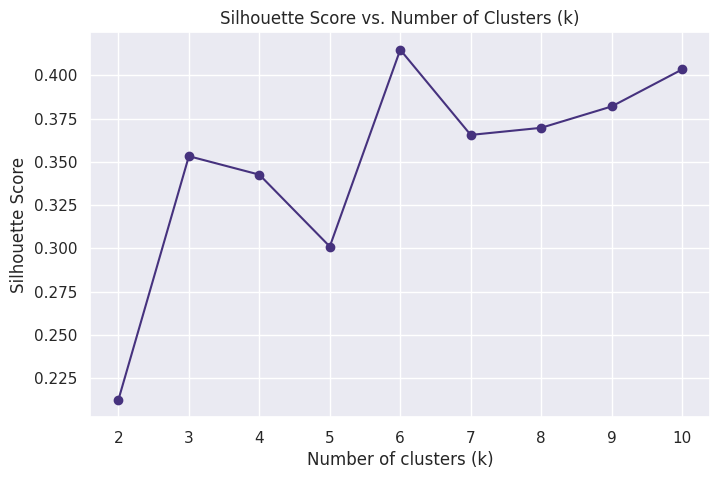

In [27]:
import matplotlib.pyplot as plt

ks, scores = zip(*silhouette_scores)
plt.figure(figsize=(8, 5))
plt.plot(ks, scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters (k)")
plt.grid(True)
plt.show()


The highest silhouette score achieved for k=6 , thats why we will re-run the k-means for optimal k=6 for better clustering performance.

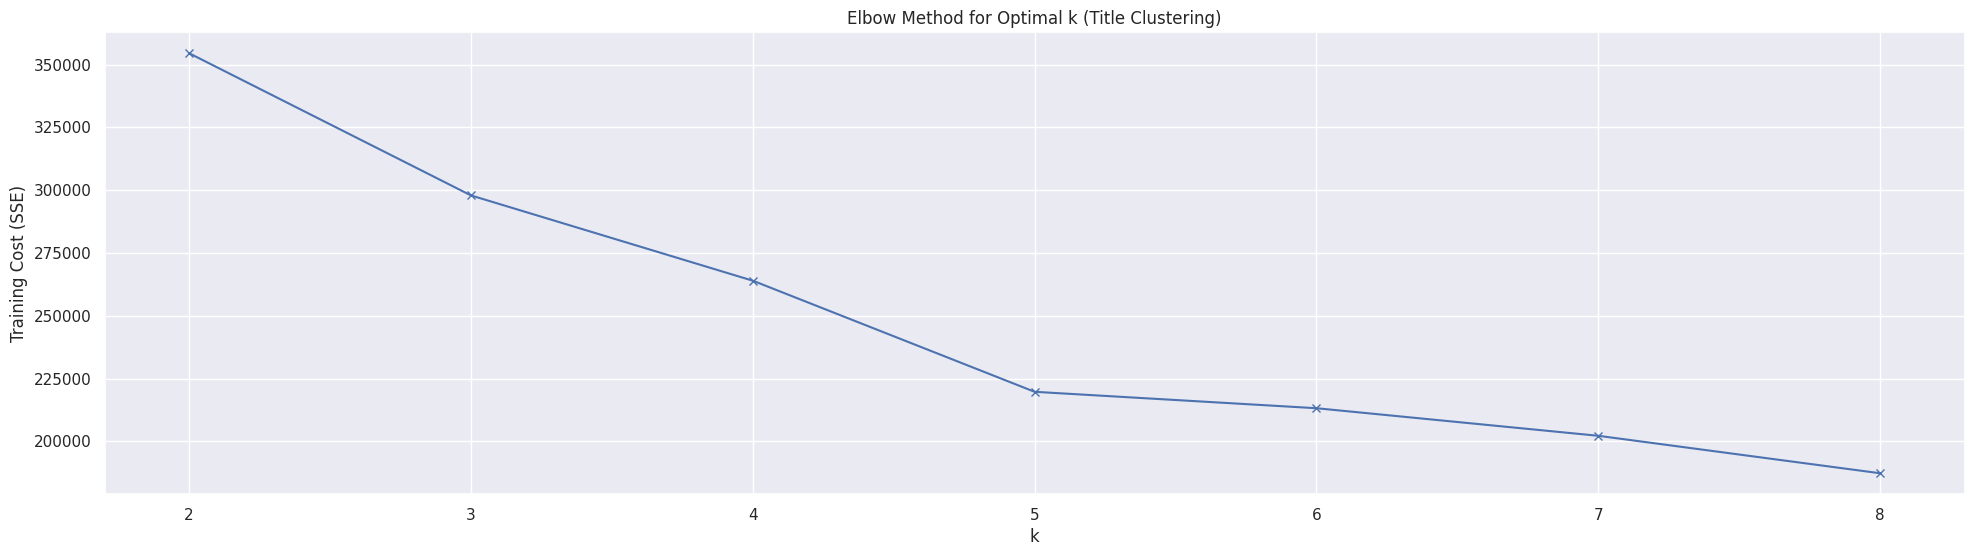

In [33]:
def elbow_method(x):
    from pyspark.ml.clustering import KMeans
    costs = []
    ks = [2, 3, 4, 5, 6, 7, 8]

    for k in ks:
        kmeans = KMeans(k=k, seed=1, featuresCol="genre_features")
        model = kmeans.fit(x)
        costs.append(model.summary.trainingCost)

    import matplotlib.pyplot as plt
    plt.plot(ks, costs, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Training Cost (SSE)')
    plt.title('Elbow Method for Optimal k (Title Clustering)')
    plt.show()

elbow_method(df_text)

In [28]:
from pyspark.ml.clustering import KMeans

# Best k from silhouette analysis
k_best = 6

# Fit KMeans model with k=6
kmeans_final = KMeans(featuresCol="genre_features", predictionCol="genre_cluster", k=k_best, seed=42)
kmeans_model = kmeans_final.fit(df_text)

# Assign clusters to the original DataFrame
df_clustered = kmeans_model.transform(df_text)

# Show results with cluster assignments
df_clustered.select("primaryTitle", "genres", "genre_cluster").show(20, truncate=False)


+--------------------------------------+-----------------------+-------------+
|primaryTitle                          |genres                 |genre_cluster|
+--------------------------------------+-----------------------+-------------+
|Locura de amor                        |Drama                  |2            |
|Don Juan de Serrallonga               |Adventure,Drama        |3            |
|Les Misérables, Part 1: Jean Valjean  |Drama                  |2            |
|Oedipus Rex                           |Drama                  |2            |
|Nell Gwynne                           |Biography,Drama,History|2            |
|Anfisa                                |Drama                  |2            |
|Anny - Story of a Prostitute          |Drama,Romance          |2            |
|The Great Circus Catastrophe          |Drama                  |2            |
|The Flying Circus                     |Drama                  |2            |
|From the Manger to the Cross          |Biography,Dr

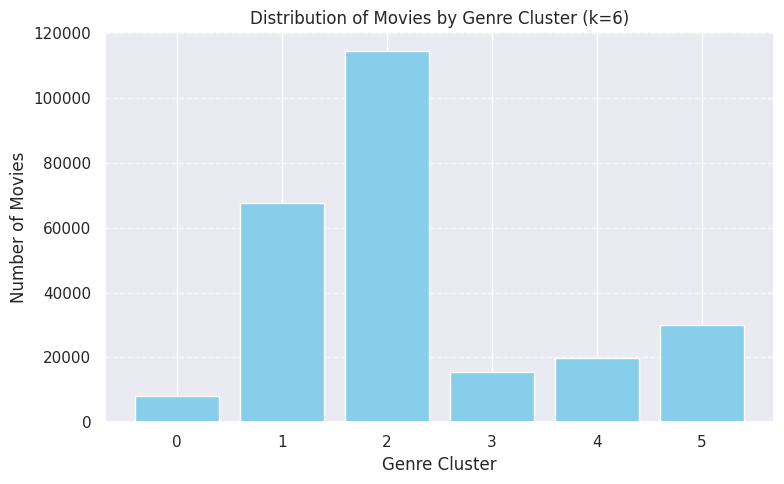

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Get cluster counts from Spark
cluster_counts = df_clustered.groupBy("genre_cluster").count().orderBy("genre_cluster").toPandas()

# Plot
plt.figure(figsize=(8, 5))
plt.bar(cluster_counts["genre_cluster"], cluster_counts["count"], color='skyblue')
plt.xlabel("Genre Cluster")
plt.ylabel("Number of Movies")
plt.title("Distribution of Movies by Genre Cluster (k=6)")
plt.xticks(cluster_counts["genre_cluster"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Cluster 2 dominates the distribution, representing nearly 120,000 movies, suggesting a broad/popular genre combination, such as mainstream Drama or Action-Comedy blends.

Cluster 1 is also prominent, containing approximately 70,000 movies, likely tied to widely occurring genres like Romance or Family.

Clusters 3, 4 and 5 represent more niche groupings, potentially tied to specific genre themes (e.g., horror/mystery or historical/biographical).

Cluster 0, the smallest group, may reflect either outlier genre mixes or underrepresented film types such as experimental, documentary, or foreign language categories.

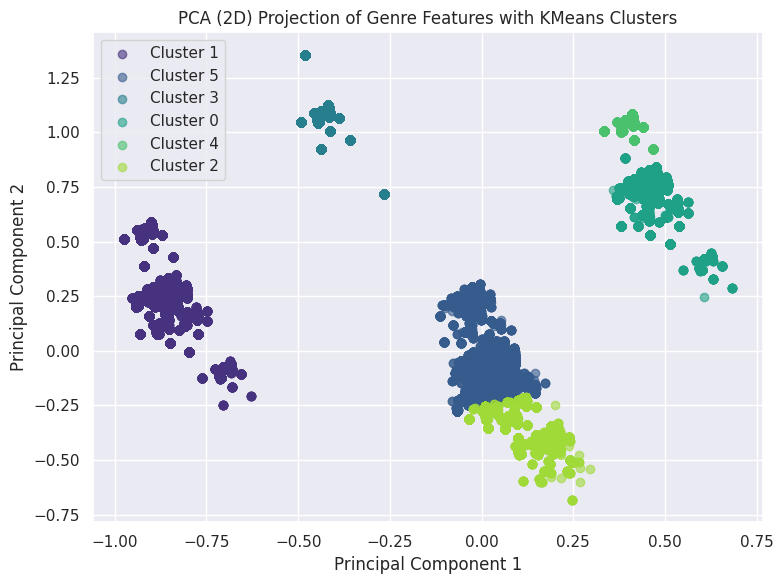

In [45]:
from pyspark.ml.feature import PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors
import pandas as pd
import matplotlib.pyplot as plt

# Run PCA to reduce to 2D for plotting
pca_2d = PCA(k=2, inputCol="genre_features", outputCol="pca_2d_features")
pca_model_2d = pca_2d.fit(df_text)
df_pca_2d = pca_model_2d.transform(df_text)

# Fit KMeans on the 2D PCA output
kmeans = KMeans(featuresCol="pca_2d_features", predictionCol="pca_cluster", k=6, seed=42)
kmeans_model = kmeans.fit(df_pca_2d)
df_clustered_2d = kmeans_model.transform(df_pca_2d)

# Extract PCA coordinates and cluster labels
pandas_df = df_clustered_2d.select("pca_2d_features", "pca_cluster").toPandas()
pandas_df[["x", "y"]] = pandas_df["pca_2d_features"].apply(lambda v: pd.Series(v.toArray()))
pandas_df["cluster"] = pandas_df["pca_cluster"]

# Plot
plt.figure(figsize=(8, 6))
for c in pandas_df["cluster"].unique():
    subset = pandas_df[pandas_df["cluster"] == c]
    plt.scatter(subset["x"], subset["y"], label=f"Cluster {c}", alpha=0.6)

plt.title("PCA (2D) Projection of Genre Features with KMeans Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The clusters appear to be well-separated, with minimal overlap in most areas, suggesting that the KMeans algorithm has successfully partitioned the genre space.
Clusters 0, 2, and 4 form distinct and compact groupings, indicating high intra-cluster similarity.
Cluster 5 exhibits moderate spread, which may reflect a more diverse set of genre combinations or transitional genre blends.